In [42]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt 
from torchvision.transforms import ToTensor
from torch.autograd import Variable


Original-----------------------------------------


Epoch # 1-----------------------------------------


Epoch # 2-----------------------------------------


Epoch # 3-----------------------------------------


Epoch # 4-----------------------------------------


Epoch # 5-----------------------------------------


Smoothing-----------------------------------------


Epoch # 1-----------------------------------------


Epoch # 2-----------------------------------------


Epoch # 3-----------------------------------------


Epoch # 4-----------------------------------------


Epoch # 5-----------------------------------------



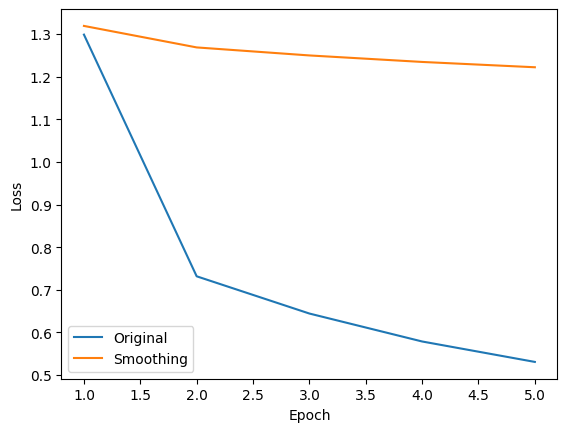

In [43]:
# model 구성
    
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x

# Label Smoothing을 적용한 경우의 Loss function 정의

class LabelSmoothingLoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = num_classes
        self.dim = dim
        
    def forward(self, pred, target): # pred.size(): [batch_size, num_classes]
        assert 0 <= self.smoothing < 1
        
        pred = pred.log_softmax(dim=self.dim) # softmax --> logarithm
        
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            
            true_dist.fill_(self.smoothing / (self.cls - 1))
            
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
                # scatter_(dim, index, src): index에 맞게 src(tensor)의 값을 tensor로 할당
        
        return torch.mean(torch.sum(- true_dist * pred, dim=self.dim)) 
            # true_dist와 pred가 유사할수록, true_dist * pred 값이 커지고, return 값 (loss 값)이 작아짐
            # * -> element-wise multiplication
            # torch.sum() -> 각 행의 num_classes개의 element 값을 다 더함

# data set, data loader 준비

train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=ToTensor(), download=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# model, optimizer, criterion 준비

model = MyModel()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_classes = 10

criterion = LabelSmoothingLoss(num_classes, smoothing=0.0)
smoothing_criterion = LabelSmoothingLoss(num_classes, smoothing=0.2)

num_epochs = 5

# Smoothing 안한 경우 Training

losses_list = []

print("\nOriginal-----------------------------------------\n")

for epoch in range(num_epochs):
    print(f"\nEpoch # {epoch + 1}-----------------------------------------\n")
    
    losses = 0.0
    
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        losses += loss.item()
        
    losses_list.append(losses / len(train_dataloader))
    
# smoothing 한 경우 Training
    
smoothing_losses_list = []

print("\nSmoothing-----------------------------------------\n")

for epoch in range(num_epochs):
    print(f"\nEpoch # {epoch + 1}-----------------------------------------\n")
    
    smoothing_losses = 0.0
    
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        
        smoothing_outputs = model(images)
        
        smoothing_loss = smoothing_criterion(smoothing_outputs, labels)
        
        smoothing_loss.backward()
        
        optimizer.step()
        
        smoothing_losses += smoothing_loss.item()
        
    smoothing_losses_list.append(smoothing_losses / len(train_dataloader))
    
# loss 비교

epoch_range = range(1, num_epochs + 1)

plt.plot(epoch_range, losses_list, label = 'Original')
plt.plot(epoch_range, smoothing_losses_list, label = 'Smoothing')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()